In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.linalg import expm, sinm, cosm
from sympy import *
a,b,c,d,e,f,g,h,t,U = symbols('a,b,c,d,e,f,g,h,t,U')

In [2]:
precission = 0.001

In [3]:
class experiment():

    def __init__(self):
        super().__init__()
        self.T = 0.08617
        self.xrange = 10
        self.lt = 0.005
        self.ptip = [0,0,0]
        self.psample = [0,0,0]
        self.atom = {'S':1.5, 'g':2, 'D':2.7, 'E':0.5, 'J':-0.25, 'U':0, 'w':20}
        self.eigenvec = np.array([[-0.1332256,0,0,-0.9910857],
                         [0, 0.9829937,0.1836392,0],      
                        [0.9910857,0, 0, -0.1332256],
                        [0, -0.1836392, 0.9829937,0 ]])
        self.eigenval = np.array([0.3270655,0.7447324,5.5422276,6.8859745])
        self.position = 1
        self.jposition = 1
        self.A = 1
        self.b = 0
        self.x0 = 0
        self.y0 = 0
        self.B = [0,0,4]
        self.matrix = '1'
        self.matrixDM = '0,0,0'
        self.heisenberg_coupling  = 0
        self.sample_entanglemen = True
        self.sef = 1
        self.paramagnetic = False
        self.paramag_S = 2.5
        self.paramag_g = 2
        self.eta = 0.3
        self.no_eval = 1000
        self.max_no_eigenstates = 50
        self.third_order_calc = True
        self.rate_calc = False
        self.entanglement = False
        self.allatomsequ = 0
        self.sw = [True, False, False, True, True, False, True, False, \
                   False, False, True, False, False]
        

In [4]:
def clean(m, esp):
    m[abs(m)<esp] = 0
    return m

In [5]:
def sparse(S):
    return S

In [6]:
def isvector(v):
    if np.array(v).ndim == 1:
        return True
    else:
        return False

In [7]:
def dmatrix(n):
    ss = {'S':0.5}
    e=1/2*S1(ss)+n[0]*Sx(ss)+n[1]*Sy(ss)+n[2]*Sz(ss)
    return e

In [8]:
def spec(m):
    d = np.linalg.eig(m)
    return d[1], d[0]

In [9]:
def Rate2nd2(exp):
    [x, y, z, u] = etransport(exp)
    E = exp.eigenvec
    S = exp.atom
    matrxx = Sx(S)
    matrxy = Sy(S)
    matrxz = Sz(S)
    matrxu = S['U']*S1(S)

    matrxx = np.dot(np.dot(np.conj(E.T),matrxx),E)
    matrxy = np.dot(np.dot(np.conj(E.T),matrxy),E)
    matrxz = np.dot(np.dot(np.conj(E.T),matrxz),E)
    matrxu = np.dot(np.dot(np.conj(E.T),matrxu),E)
    
    out = 0
    for i in range(4):
        out = out + abs(matrxx*x.flatten()[i]+matrxy*y.flatten()[i]+matrxz*z.flatten()[i]+matrxu*u.flatten()[i])\
        *abs(matrxx*x.flatten()[i]+matrxy*y.flatten()[i]+matrxz*z.flatten()[i]+matrxu*u.flatten()[i])
    
    return out

In [10]:
def etransport(exp):
    e = {'S':0.5}
    dt=dmatrix(exp.ptip)
    ds=dmatrix(exp.psample)
    wt,pt=spec(dt)
    ws,ps=spec(ds)
    
    ps = ps[:, np.newaxis]
    pt = pt[:, np.newaxis]
    pp=np.sqrt(np.kron(ps, np.conj(pt.T)))

    x=np.dot(np.conj(ws.T),np.dot(2*Sx(e),wt))*pp
    y=np.dot(np.conj(ws.T),np.dot(2*Sy(e),wt))*pp
    z=np.dot(np.conj(ws.T),np.dot(2*Sz(e),wt))*pp
    u=-2*np.dot(np.conj(ws.T),wt)*pp
#     print('--x\n',x,'\n--y\n',y,'\n--z\n',z,'\n--u\n',u)
    return x,y,z,u

In [11]:
def Splus(S):
    a = np.arange(1,2*S['S']+1)
    b = np.arange(2*S['S'],0,-1)
    e = np.sqrt(a*b)
    ee = diag(e,1)
    return ee

def Sminus(S):
    a = np.arange(1,2*S['S']+1)
    b = np.arange(2*S['S'],0,-1)
    e = np.sqrt(a*b)
    ee = diag(e,-1)
    return ee

def Sx(S):
    return 0.5*(Splus(S)+Sminus(S))
def Sy(S):
    return -0.5*1j*(Splus(S)-Sminus(S))
def Sz(S):
    return diag(np.arange(S['S'],-S['S']-1,-1))
def S1(S):
    return diag(np.ones((int(S['S']*2)+1,1)).flatten().tolist())

In [12]:
def diag(evals, k=0):
    e = np.zeros((len(evals)+abs(k),len(evals)+abs(k)))
    for i in range(e.shape[0]):
        if i+k<=e.shape[0]-1 and i+k>=0:
            e[i,i+k] = evals[i+k] if k<=0 else evals[i]
        else:
            continue
    return e

In [13]:
def Occupation(ve, T):
    ve = np.real(ve)
    if ve.ndim > 1 and ve.shape[0] == ve.shape[1]:
        ve = diag(ve)
    ve = ve - np.min(ve)
    if T != 0:
        e = np.exp(-ve/T)
        e = e / np.sum(e)
    else:
        bb = ve.shape
        e[:bb[0]+1] = 0
        k = np.min(ve)
        e[ve.tolist().index(k)] = 1
        e = e / np.sum(e)
    
    return e

In [14]:
def fstep(x):
    x = clean(x, 1e-5)
    z = np.exp(x)
    y = (1+(x-1)*z)/((z-1)*(z-1))
    y[y==0] = 0.5
    y[np.isnan(y)] = 0
    return y

In [38]:
def spec2(exp):
    ve = np.real(exp.eigenval)
    if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
    ve = ve-np.min(np.real(ve))
    occ = Occupation(ve, exp.T)
    rate = np.conj(Rate2nd2(exp).T)
    rateneg = np.conj(rate.T)
    
    if isvector(exp.xrange):
        x = exp.xrange
    else:
        x = np.conj(np.linspace(abs(exp.xrange),-abs(exp.xrange),1000).T)
        
    y = 0
    a = exp.eigenvec.shape
    for i in range(a[1]):
        if occ[i] > precission:
            for j in range(a[1]):
                print('---',i,j,'----')
                en = (ve[j]-ve[i]-x)/abs(exp.T)
                ep = (ve[j]-ve[i]+x)/abs(exp.T)
                ytemp = occ[i]*(rate[i,j]*fstep(ep)+rateneg[i,j]*fstep(en))
                y = y+ytemp
                
    return x, y 

        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)

--- 0 0 ----
--- 0 1 ----
--- 0 2 ----
--- 0 3 ----
--- 1 0 ----
--- 1 1 ----
--- 1 2 ----
--- 1 3 ----


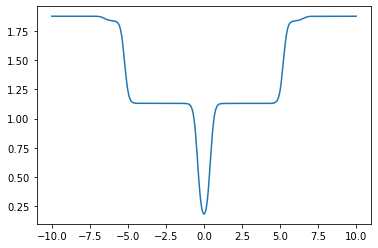

1.1303541815040439 1.0723827125812917 23.349332853800767 9.337448211745107e-34
True
True
False
False


In [39]:
exp = experiment()
x, y = spec2(exp)
plt.plot(x,y)
plt.show()



# ve = np.real(exp.eigenval)
# if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
#     d = np.linalg.eig(ve)[1]
#     ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
# ve = ve-np.min(np.real(ve))
# occ = Occupation(ve, exp.T)
# rate = np.conj(Rate2nd2(exp).T)
# rateneg = np.conj(rate.T)

# if isvector(exp.xrange):
#     x = exp.xrange
# else:
#     x = np.conj(np.linspace(abs(exp.xrange),-abs(exp.xrange),1000).T)

# y = 0
# a = exp.eigenvec.shape

i =3;j=3
en = (ve[j]-ve[i]-x)/abs(exp.T)
ep = (ve[j]-ve[i]+x)/abs(exp.T)
ytemp = occ[i]*(rate[i,j]*fstep(ep)+rateneg[i,j]*fstep(en))
# y = y+ytemp

print(y[399],  rateneg[3,3], ep[399], ytemp[399])
for k in range(a[1]):
    print(occ[k]> precission)

(1000, 2)


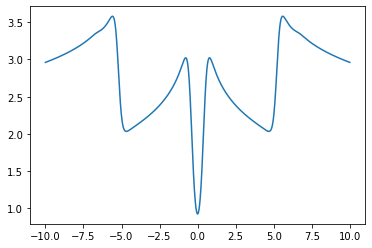

In [28]:
data = np.loadtxt('./co.dat')
print(data.shape)
xx = data[:,0]; yy=data[:,1]
plt.plot(xx,yy)
plt.show()